In [1]:
#Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Model libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, recall_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier

# Data Import

In [3]:
data = pd.read_csv('intrusion_detection_notonehot.csv')

# Data Cleaning

In [4]:
print(f'Amount of NaN-Values in the entire data set: {sum(data.isnull().sum())}')

Amount of NaN-Values in the entire data set: 0


In [5]:
data.dtypes.value_counts()

float64    38
object      4
int64       2
dtype: int64

# EDA

## Variable selection

* `num_outbounds_cmds`,`land`,`Unnamed: 0`, `id` are dropped
* We will select `outlier@{no,yes}` as the target variable

In [6]:
data.shape

(48113, 44)

In [7]:
data.nunique()

Unnamed: 0                     48113
duration                         238
src_bytes                       2375
dst_bytes                       9169
wrong_fragment                     3
urgent                             3
hot                               18
num_failed_logins                  3
logged_in                          2
num_compromissed                  18
root_shell                         2
su_attempted                       3
num_root                          15
num_file_creations                12
num_shells                         4
num_access_files                   5
num_outbounds_cmds                 1
is_host_login                      2
is_guest_login                     2
count                            335
srv_count                        341
serror_rate                       21
srv_serror_rate                   29
rerror_rate                        6
srv_rerror_rate                   32
same_srv_rate                     66
diff_srv_rate                     83
s

In [41]:
def n_counts_per(dataframe,unique_values = 1):
    for column in dataframe.columns[dataframe.nunique().values == unique_values]:
        print(dataframe[column].value_counts())
        print('----')

In [42]:
n_counts_per(data,1)

0.0    48113
Name: num_outbounds_cmds, dtype: int64
----
0    48113
Name: land, dtype: int64
----


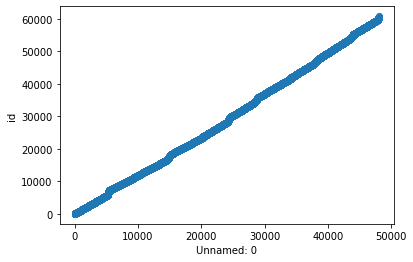

In [43]:
plt.scatter(data['Unnamed: 0'], data['id'])
plt.xlabel('Unnamed: 0')
plt.ylabel('id')
plt.show()

* `land` and `num_outbounds_cmds` only have one unique value. Therefore not very useful for our analysis.
* `Unnamed: 0` and `id` are just unique identifiers per record, that both increase in value. These aren't useful for classication either.

In [44]:
n_counts_per(data,2)

1.0    42475
0.0     5638
Name: logged_in, dtype: int64
----
0.0    48068
1.0       45
Name: root_shell, dtype: int64
----
0.0    48109
1.0        4
Name: is_host_login, dtype: int64
----
0.0    47993
1.0      120
Name: is_guest_login, dtype: int64
----
no     47913
yes      200
Name: outlier@{no,yes}, dtype: int64
----


In [9]:
200/(200+47913)*100

0.41568806767401745

* We will select `outlier@{no,yes}` as the target variable (and change (yes,no) to (1,0).
* 0.42% of connections are harmful

In [45]:
#drop columns with 1 unique value or all unique values
data = data.drop(columns= ['num_outbounds_cmds','land','Unnamed: 0', 'id'],axis=1)

#change (yes,no) in target variable to (1,0)
data['outlier@{no,yes}'] = np.where(data['outlier@{no,yes}'] == 'yes', 1, 0)

#slice numerical, categorical and target variables
cat_var = ['protocol_type','service','flag']
target = 'outlier@{no,yes}'
num_var = data.drop(columns= cat_var + [target], axis=1).columns.tolist()

## Exploration

### Categorical Variables

* By grouping together categories that had either 0% or 100% harmful connections, we are able to reduce the number of dummy variables from 41 to 19.

In [46]:
len(cat_var)

3

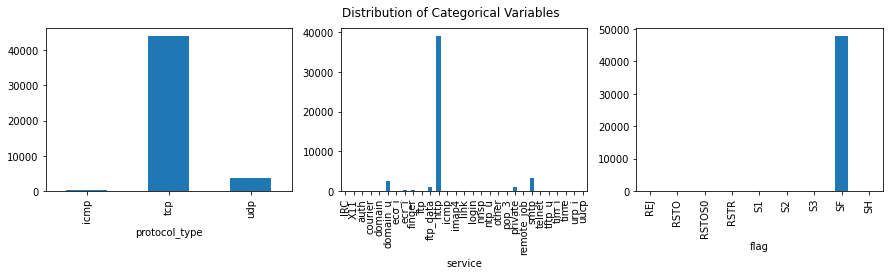

In [47]:
fig, axs = plt.subplots(1,3, figsize=(15,3))

for column, ax in zip(cat_var, axs.flatten()):
  data[column].value_counts().sort_index().plot(kind='bar',ax=ax,rot=90)
  ax.set_xlabel(column)

plt.suptitle('Distribution of Categorical Variables')
plt.show()

In [48]:
data['flag'].value_counts()

SF        47899
SH           80
REJ          49
RSTR         47
S1           17
S2           13
S3            4
RSTO          3
RSTOS0        1
Name: flag, dtype: int64

In [49]:
def freq_target_table(column):
    '''
    Gives the frequency of target values per categorical value of the column
    '''
    table=pd.crosstab(data[column],data[target])
    return table.div(table.sum(1).astype(float), axis=0)

In [50]:
len(freq_target_table('protocol_type')) + len(freq_target_table('service')) + len(freq_target_table('flag'))

41

In [51]:
freq_target_table('protocol_type')

"outlier@{no,yes}",0,1
protocol_type,,
icmp,0.835125,0.164875
tcp,0.996958,0.003042
udp,0.994723,0.005277


In [52]:
freq_target_table('flag')

"outlier@{no,yes}",0,1
flag,,
REJ,0.979592,0.020408
RSTO,0.666667,0.333333
RSTOS0,1.000000,0.000000
RSTR,1.000000,0.000000
S1,1.000000,0.000000
S2,1.000000,0.000000
S3,1.000000,0.000000
SF,0.997536,0.002464
SH,0.000000,1.000000


In [53]:
freq_target_table('service')

"outlier@{no,yes}",0,1
service,,
IRC,1.000000,0.000000
X11,1.000000,0.000000
auth,1.000000,0.000000
courier,0.000000,1.000000
domain,0.000000,1.000000
domain_u,1.000000,0.000000
eco_i,1.000000,0.000000
ecr_i,0.763314,0.236686
finger,1.000000,0.000000


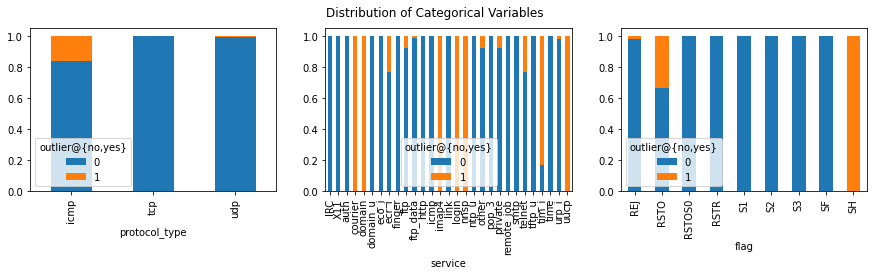

In [54]:
fig, axs = plt.subplots(1,3, figsize=(15,3))

for column, ax in zip(cat_var, axs.flatten()):

    freq_target_table(column).plot(kind='bar', stacked=True,ax=ax)
    ax.set_xlabel(column)

plt.suptitle('Distribution of Categorical Variables')
plt.show()

* We can group the values that have no harmful cases together, and reduce the amount of dummy variables needed for modeling.

* Based on the values that contain zero in the harm column of the frequency table, we group those categories together.

* We can also group the categories that are 100% harmful together

In [55]:
data['flag'] = np.where(data['flag'].isin(freq_target_table('flag')[freq_target_table('flag')[1]==0].index.tolist()),
                        'NoHarm',data['flag'])
data['service'] = np.where(data['service'].isin(freq_target_table('service')[freq_target_table('service')[1]==0].index.tolist()),
                        'NoHarm',data['service'])
data['service'] = np.where(data['service'].isin(freq_target_table('service')[freq_target_table('service')[1]==1].index.tolist()),
                        'Harm',data['service'])

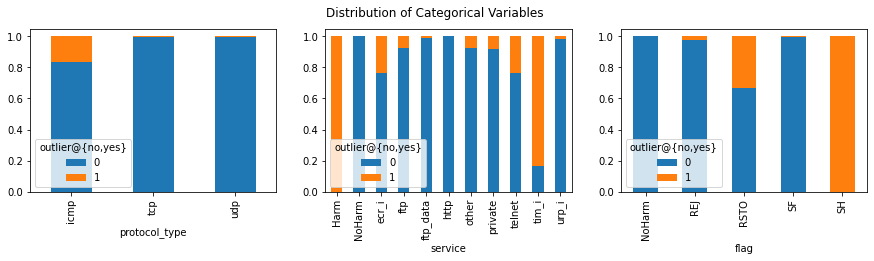

In [56]:
fig, axs = plt.subplots(1,3, figsize=(15,3))

for column, ax in zip(cat_var, axs.flatten()):

    freq_target_table(column).plot(kind='bar', stacked=True,ax=ax)
    ax.set_xlabel(column)

plt.suptitle('Distribution of Categorical Variables')
plt.show()

### Numerical Variables

* The idea was to remove variables that are highly correlated (> 0.8) within the **subset of harmful connections**.

* For some reason it completely destroyed the models performance and wasn't included in the final model. However it is something that could be taken into account for later optimizations of the model.

In [57]:
len(num_var)

36

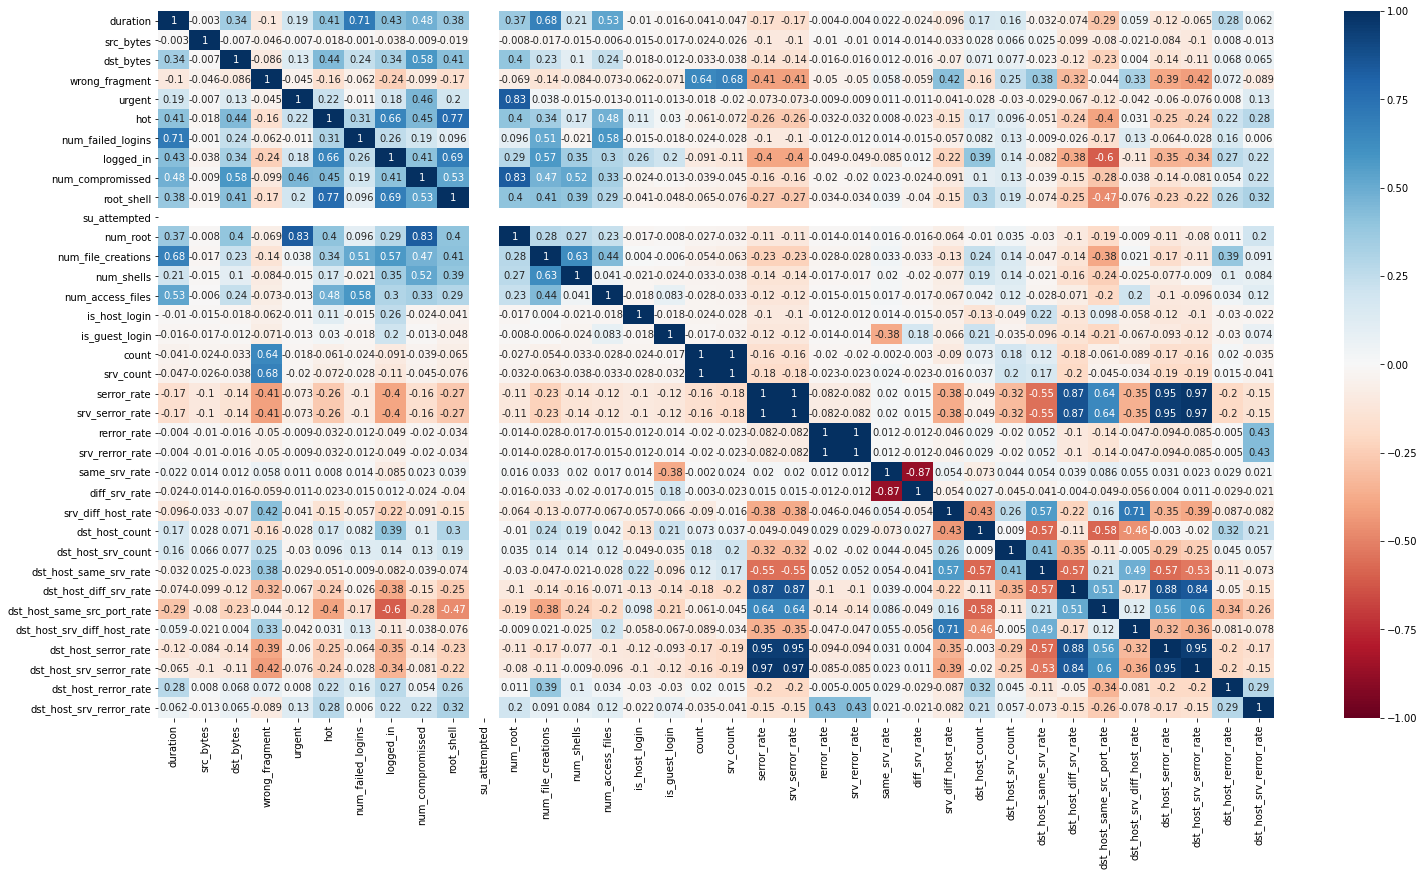

In [58]:
fig, ax = plt.subplots(1,1, figsize=(25,13))

sns.heatmap(data[num_var][data[target] == 1].corr().round(3), vmin=-1,vmax=1,cmap='RdBu',annot=True,ax=ax)

plt.show()

Since dealing with 36 numerical variables is a little excessive, we choose an absolute correlation > 0.8 within the hostile slice of the dataset as a cut off point for feature selection. 

We can therefore eliminate:
* `srv_count`, `srv_serror_rate`, `srv_rerror_rate`, `num_root`, `diff_srv_rate`, `dst_diff_host_srv_rate`, `dst_host_serror_rate`, `dst_host_srv_serror_rate`

In [59]:
remove_list = ['srv_count', 'srv_serror_rate', 'srv_rerror_rate',
               'num_root', 'diff_srv_rate', 'dst_host_diff_srv_rate',
               'dst_host_serror_rate', 'dst_host_srv_serror_rate']

for item in remove_list:
    num_var.remove(item)

In [60]:
len(num_var)

28

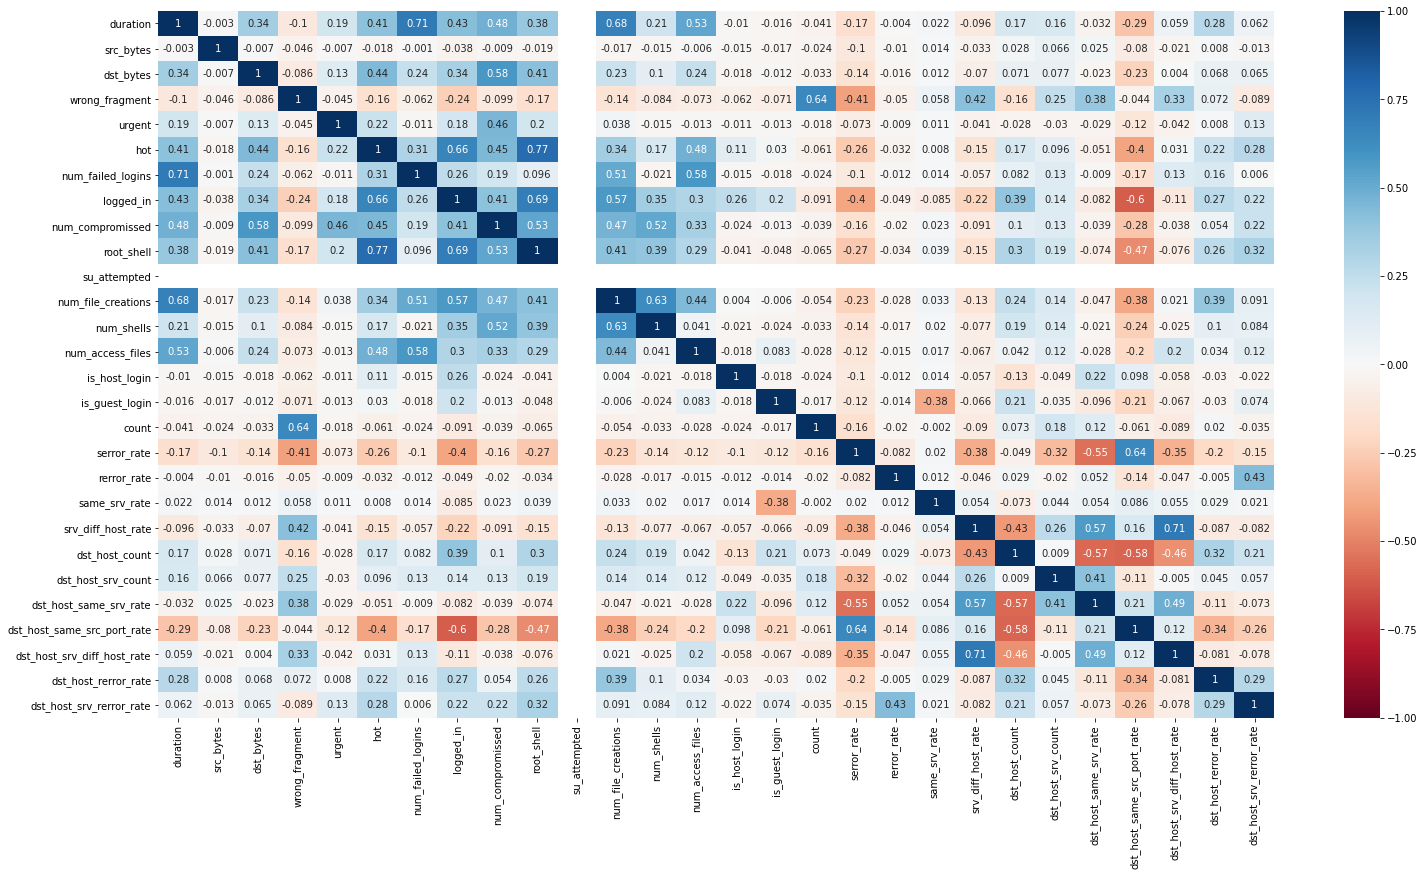

In [61]:
fig, ax = plt.subplots(1,1, figsize=(25,13))

sns.heatmap(data[num_var][data[target] == 1].corr().round(3), vmin=-1,vmax=1,cmap='RdBu',annot=True,ax=ax)

plt.show()

# Model Selection

**Feature Selection**

* We remove variables that have an absolute coefficient value of less than 0.346 in the Null Model.

The best recall score is achieved with a Logistic Regression. The model parameters are:

* `C`: `1e-06`
* `class_weight`: `balanced`
* `penalty`: `l2`
* `solver`: `liblinear`

## Null Model (Simple Logistic Regression)
* Recall Score:
    * Train 0.40540540540540543
    * Validation 0.40384615384615385

In [62]:
len(num_var)

28

In [63]:
len(cat_var)

3

In [64]:
#set the variable
x = data[num_var]
x = pd.concat([x,pd.get_dummies(data[cat_var])],axis=1)
y = data[target]

x_train, x_val, y_train, y_val = train_test_split(x,y,
                                                  test_size = 0.2,
                                                  random_state = 42)

#set the model
#clf stands for classifier
null = LogisticRegression(max_iter=1000)

#fit the model
null.fit(x_train,y_train)

LogisticRegression(max_iter=1000)

In [65]:
print(classification_report(y_train,null.predict(x_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     38342
           1       0.92      0.07      0.14       148

    accuracy                           1.00     38490
   macro avg       0.96      0.54      0.57     38490
weighted avg       1.00      1.00      0.99     38490



In [66]:
print(classification_report(y_val,null.predict(x_val)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9571
           1       1.00      0.13      0.24        52

    accuracy                           1.00      9623
   macro avg       1.00      0.57      0.62      9623
weighted avg       1.00      1.00      0.99      9623



In [67]:
print(recall_score(y_train,null.predict(x_train)))
print(recall_score(y_val,null.predict(x_val)))

0.07432432432432433
0.1346153846153846


In [70]:
coef_df = pd.Series(null.coef_.round(3)[0],
          index = x.columns)

cutoff = 0.346

print(f'Amount of Variables left after cut-off at |{cutoff}|: {len(coef_df[abs(coef_df) > cutoff])}')
print('----')
print(coef_df[abs(coef_df) > cutoff])

Amount of Variables left after cut-off at |0.346|: 10
----
wrong_fragment            0.420
logged_in                -0.372
serror_rate               0.384
same_srv_rate            -0.668
dst_host_same_srv_rate   -0.468
protocol_type_tcp        -0.647
service_NoHarm           -0.960
service_private           0.412
flag_SF                  -1.058
flag_SH                   0.390
dtype: float64


In [71]:
var_null = coef_df[abs(coef_df) > cutoff].index.tolist()

## Logistic Regression
* Recall Score:
    * Train 0.9797297297297297
    * Validation 0.9807692307692307

* {'clf__C': 1e-06,
 'clf__class_weight': 'balanced',
 'clf__penalty': 'l2',
 'clf__solver': 'liblinear'}

In [0]:
# The 'newton-cg', 'sag' and 'lbfgs' solvers support only l2 penalties. 'elasticnet' is  
# only supported by the 'saga' solver. If 'none' (not supported by the  
# liblinear solver), no regularization is applied.  

# - 'newton-cg', 'lbfgs', 'sag' and 'saga' handle L2 or no penalty  
# - 'liblinear' and 'saga' also handle L1 penalty  
# - 'saga' also supports 'elasticnet' penalty  
# - 'liblinear' does not support setting `penalty='none'`

params_none = {'clf__penalty': ['none'],
               'clf__solver': ['lbfgs','newton-cg','sag','saga'],
               'clf__class_weight': ['balanced']}

params_l1 = {'clf__penalty': ['l1'],
             'clf__solver': ['liblinear','saga'],
             'clf__C': np.logspace(-6,1,4),
             'clf__class_weight': ['balanced']}           

params_l2 = {'clf__penalty': ['l2'],
             'clf__solver': ['liblinear','lbfgs','newton-cg','sag','saga'],
             'clf__C': np.logspace(-6,1,4),
             'clf__class_weight': ['balanced']}

params_en = {'clf__penalty': ['elasticnet'],
             'clf__solver': ['saga'],
             'clf__C': np.logspace(-6,1,4),
             'clf__l1_ratio': np.arange(0,1,0.2),
             'clf__class_weight': ['balanced']}

In [0]:
#These are the best parameters for each penalty, ElasticNet ran too long so we excluded it from the model
params_none = {'clf__penalty': ['none'],
               'clf__solver': ['lbfgs'],
               'clf__class_weight': ['balanced']}

params_l1 = {'clf__penalty': ['l1'],
             'clf__solver': ['liblinear'],
             'clf__C': [0.01],
             'clf__class_weight': ['balanced']}          

params_l2 = {'clf__penalty': ['l2'],
             'clf__solver': ['liblinear'],
             'clf__C': [1e-06],
             'clf__class_weight': ['balanced']}

In [0]:
#set the variable
x = data[num_var]
x = pd.concat([x,pd.get_dummies(data[cat_var])],axis=1)
x = x[var_null]
y = data[target]

#Train validation data split
x_train, x_val, y_train, y_val = train_test_split(x,y,test_size = 0.2,random_state = 42)

# Set the parameters by cross-validation
super_params = [params_none, params_l1, params_l2]

#Make pipe, but change solver
pipe = Pipeline(steps = [('scaler', StandardScaler()), 
                        ('clf', LogisticRegression(random_state=42,max_iter=10000))])

clf_log = GridSearchCV(pipe, param_grid = super_params, scoring = 'recall',
                   cv=3, n_jobs = -1)

clf_log.fit(x_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('clf',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=10000,
                                                           multi_class='auto',
           

In [0]:
 clf_log.best_params_

{'clf__C': 1e-06,
 'clf__class_weight': 'balanced',
 'clf__penalty': 'l2',
 'clf__solver': 'liblinear'}

In [0]:
pd.DataFrame(clf_log.cv_results_).sort_values(by='mean_test_score',ascending=False).transpose()

,2,1,0
mean_fit_time,0.0615885,0.164891,0.277149
std_fit_time,0.0104971,0.0161505,0.0331429
mean_score_time,0.00949415,0.0104651,0.0103633
std_score_time,0.00160255,0.000338449,0.000745278
param_clf__class_weight,balanced,balanced,balanced
param_clf__penalty,l2,l1,none
param_clf__solver,liblinear,liblinear,lbfgs
param_clf__C,1e-06,0.01,NaN
params,"{'clf__C': 1e-06, 'clf__class_weight': 'balanc...","{'clf__C': 0.01, 'clf__class_weight': 'balance...","{'clf__class_weight': 'balanced', 'clf__penalt..."
split0_test_score,0.959184,0.938776,0.938776


## Best Estimator (Logistic Regression)

In [75]:
?LogisticRegression

In [76]:
#set the variable
x = data[num_var]
x = pd.concat([x,pd.get_dummies(data[cat_var])],axis=1)
x = x[var_null]
y = data[target]

#Train validation data split
x_train, x_val, y_train, y_val = train_test_split(x,y,test_size = 0.2,random_state = 42)

#Make pipe, using the best parameters
clf_bestlog = Pipeline(steps = [('scaler', StandardScaler()), 
                        ('clf', LogisticRegression(random_state=42,max_iter=10000,
                                                  C = 1e-06,
                                                  class_weight = 'balanced',
                                                  penalty = 'l2',
                                                  solver = 'liblinear'))])

clf_bestlog.fit(x_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 LogisticRegression(C=1e-06, class_weight='balanced',
                                    max_iter=10000, random_state=42,
                                    solver='liblinear'))])

In [77]:
print(recall_score(y_train,clf_bestlog.predict(x_train)))
print(recall_score(y_val,clf_bestlog.predict(x_val)))

0.9797297297297297
0.9807692307692307


In [78]:
print(classification_report(y_train,clf_bestlog.predict(x_train)))

              precision    recall  f1-score   support

           0       1.00      0.84      0.91     38342
           1       0.02      0.98      0.04       148

    accuracy                           0.84     38490
   macro avg       0.51      0.91      0.48     38490
weighted avg       1.00      0.84      0.91     38490



In [79]:
print(classification_report(y_val,clf_bestlog.predict(x_val)))

              precision    recall  f1-score   support

           0       1.00      0.84      0.91      9571
           1       0.03      0.98      0.06        52

    accuracy                           0.84      9623
   macro avg       0.52      0.91      0.49      9623
weighted avg       0.99      0.84      0.91      9623



## KNN

* Recall Score:
    * Train 0.7702702702702703
    * Validation 0.7307692307692307

* {'knn__n_neighbors': 14, 'knn__p': 1, 'knn__weights': 'distance'}

In [0]:
#Setting the variables
x_knn = data[num_var]
x_knn = pd.concat([x,pd.get_dummies(data[cat_var])],axis=1)
x_knn = x[var_null]
y_knn = data[target]

#set numerical variables of model for transformation
numerical_variables = [item for item in num_var if item in var_null]

In [0]:
#train validation data split
x_knn_train, x_knn_val, y_knn_train, y_knn_val = train_test_split(x_knn,
                                                                  y_knn,
                                                                  test_size = 0.2,
                                                                  random_state = 42)

In [0]:
#set Transformer
knn_transformer = ColumnTransformer(transformers =
                                    [('scaler', MinMaxScaler(), numerical_variables)],
                                    remainder = 'passthrough',
                                    verbose = True)

In [0]:
#make pipeline with column transformer and KNN
knn_pipe = Pipeline(steps= [('transform', knn_transformer),
                            ('knn',KNeighborsClassifier())],
                    verbose=True)

In [0]:
params = {'knn__n_neighbors': np.arange(4,16,2),
            'knn__weights': ['uniform','distance'],
            'knn__p': [1,2]}

In [0]:
#Set grid search
clf_knn = GridSearchCV(knn_pipe,
                            params, 
                            scoring = 'recall', 
                            cv = 3, 
                            n_jobs = -1, 
                            verbose = 1,
                            return_train_score = True)

In [0]:
clf_knn.fit(x_knn, y_knn)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 21.2min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 33.1min finished


[ColumnTransformer] ........ (1 of 2) Processing scaler, total=   0.0s
[ColumnTransformer] ..... (2 of 2) Processing remainder, total=   0.0s
[Pipeline] ......... (step 1 of 2) Processing transform, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing knn, total=   4.2s


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('transform',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('scaler',
                                                                         MinMaxScaler(copy=True,
                                                                                      feature_range=(0,
                                                                                                     1)),
                                                                         ['wrong_fragment',
                                                                  

In [0]:
clf_knn.best_params_

{'knn__n_neighbors': 14, 'knn__p': 1, 'knn__weights': 'distance'}

In [0]:
pd.DataFrame(clf_knn.cv_results_).sort_values(by='mean_test_score',ascending=False).transpose()

,21,23,1,3,5,13,7,9,11,15,17,19,0,2,4,8,16,20,10,6,12,18,22,14
mean_fit_time,3.16013,3.10392,2.84635,3.12053,3.08036,2.76677,3.00982,2.79104,3.15134,3.08341,3.15853,2.88861,3.28058,3.10343,3.32295,3.12805,3.32918,2.99736,3.20681,3.20676,3.40563,3.34965,3.39963,2.74454
std_fit_time,0.460837,0.289683,0.161674,0.474239,0.260436,0.0378481,0.194929,0.144364,0.364906,0.432604,0.438564,0.114711,0.347437,0.38517,0.317344,0.287504,0.477522,0.21614,0.250018,0.241672,0.269243,0.238929,0.37169,0.138431
mean_score_time,17.7067,16.2809,17.2702,16.476,17.3802,17.223,16.2635,17.5587,16.3208,16.3704,17.4861,16.4012,17.9533,17.0258,18.1446,18.0837,18.122,18.1665,16.8174,16.8954,18.0109,16.9939,17.2026,16.8128
std_score_time,0.0580765,0.0707774,0.0442617,0.157047,0.060771,0.0535639,0.0534133,0.113501,0.0726363,0.0157672,0.12786,0.0493004,0.0975334,0.0663202,0.16368,0.0387199,0.100231,0.1053,0.0756322,0.0851743,0.0926875,0.0497663,0.312293,0.132706
param_knn__n_neighbors,14,14,4,4,6,10,6,8,8,10,12,12,4,4,6,8,12,14,8,6,10,12,14,10
param_knn__p,1,2,1,2,1,1,2,1,2,2,1,2,1,2,1,1,1,1,2,2,1,2,2,2
param_knn__weights,distance,distance,distance,distance,distance,distance,distance,distance,distance,distance,distance,distance,uniform,uniform,uniform,uniform,uniform,uniform,uniform,uniform,uniform,uniform,uniform,uniform
params,"{'knn__n_neighbors': 14, 'knn__p': 1, 'knn__we...","{'knn__n_neighbors': 14, 'knn__p': 2, 'knn__we...","{'knn__n_neighbors': 4, 'knn__p': 1, 'knn__wei...","{'knn__n_neighbors': 4, 'knn__p': 2, 'knn__wei...","{'knn__n_neighbors': 6, 'knn__p': 1, 'knn__wei...","{'knn__n_neighbors': 10, 'knn__p': 1, 'knn__we...","{'knn__n_neighbors': 6, 'knn__p': 2, 'knn__wei...","{'knn__n_neighbors': 8, 'knn__p': 1, 'knn__wei...","{'knn__n_neighbors': 8, 'knn__p': 2, 'knn__wei...","{'knn__n_neighbors': 10, 'knn__p': 2, 'knn__we...","{'knn__n_neighbors': 12, 'knn__p': 1, 'knn__we...","{'knn__n_neighbors': 12, 'knn__p': 2, 'knn__we...","{'knn__n_neighbors': 4, 'knn__p': 1, 'knn__wei...","{'knn__n_neighbors': 4, 'knn__p': 2, 'knn__wei...","{'knn__n_neighbors': 6, 'knn__p': 1, 'knn__wei...","{'knn__n_neighbors': 8, 'knn__p': 1, 'knn__wei...","{'knn__n_neighbors': 12, 'knn__p': 1, 'knn__we...","{'knn__n_neighbors': 14, 'knn__p': 1, 'knn__we...","{'knn__n_neighbors': 8, 'knn__p': 2, 'knn__wei...","{'knn__n_neighbors': 6, 'knn__p': 2, 'knn__wei...","{'knn__n_neighbors': 10, 'knn__p': 1, 'knn__we...","{'knn__n_neighbors': 12, 'knn__p': 2, 'knn__we...","{'knn__n_neighbors': 14, 'knn__p': 2, 'knn__we...","{'knn__n_neighbors': 10, 'knn__p': 2, 'knn__we..."
split0_test_score,0.567164,0.567164,0.283582,0.283582,0.283582,0.283582,0.283582,0.283582,0.283582,0.283582,0.268657,0.268657,0.238806,0.238806,0.208955,0.208955,0.208955,0.208955,0.208955,0.208955,0.208955,0.208955,0.208955,0.208955
split1_test_score,0.507463,0.507463,0.61194,0.537313,0.552239,0.567164,0.537313,0.537313,0.537313,0.537313,0.507463,0.507463,0.462687,0.462687,0.492537,0.477612,0.462687,0.462687,0.477612,0.477612,0.477612,0.462687,0.462687,0.462687


In [0]:
print(recall_score(y_train,clf_knn.predict(x_train)))
print(recall_score(y_val,clf_knn.predict(x_val)))

0.7702702702702703
0.7307692307692307


In [0]:
print(classification_report(y_train,clf_knn.predict(x_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     38342
           1       0.91      0.77      0.84       148

    accuracy                           1.00     38490
   macro avg       0.96      0.88      0.92     38490
weighted avg       1.00      1.00      1.00     38490



In [0]:
print(classification_report(y_val,clf_knn.predict(x_val)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9571
           1       0.93      0.73      0.82        52

    accuracy                           1.00      9623
   macro avg       0.96      0.87      0.91      9623
weighted avg       1.00      1.00      1.00      9623



## Decision Tree
* Recall Score:
    * Train 0.7702702702702703
    * Validation 0.5961538461538461

In [0]:
#Setting the variables
x_dt = data[num_var]
x_dt = pd.concat([x,pd.get_dummies(data[cat_var])],axis=1)
x_dt = x[var_null]
y_dt = data[target]

In [0]:
#train test split
x_dt_train, x_dt_val, y_dt_train, y_dt_val = train_test_split(x_dt, 
                                                                  y_dt, 
                                                                  test_size = 0.2, 
                                                                  random_state = 42)

In [0]:
#Set model
clf_dt = DecisionTreeClassifier(max_features=None, random_state=42)

#Fit model
clf_dt.fit(x_dt_train,y_dt_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [0]:
#recall score
print(recall_score(y_dt_train,clf_dt.predict(x_dt_train)))
print(recall_score(y_dt_val,clf_dt.predict(x_dt_val)))

0.7702702702702703
0.5961538461538461


In [0]:
clf_dt.max_features_

11

In [0]:
#maximum splits
clf_dt.get_depth()

15

In [0]:
clf_dt.get_n_leaves()

95

In [0]:
clf_dt.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': 42,
 'splitter': 'best'}

In [0]:
pipe_tree = Pipeline(steps= [('dt',DecisionTreeClassifier(random_state=42))])

In [0]:
param_grid = [{'dt__max_depth': np.arange(1, 15),
               'dt__min_samples_leaf': [1,2,3,4,5,6,7,8],
               'dt__max_features': ['auto', 'log2', None],
               'dt__min_samples_split': [2,3,4,5,6,7,8,9]}]

In [0]:
clf_dt2 = GridSearchCV(estimator=pipe_tree, param_grid=param_grid, scoring='recall', cv=3)

In [0]:
clf_dt2.fit(x_dt_train, y_dt_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('dt',
                                        DecisionTreeClassifier(ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features=None,
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
                                                               min_impurity_split=None,
                                                               min_samples_leaf=1,
                                                               min_samples_split=2,
                                          

In [0]:
clf_dt2.best_params_

{'dt__max_depth': 7,
 'dt__max_features': 'auto',
 'dt__min_samples_leaf': 1,
 'dt__min_samples_split': 2}

In [0]:
pd.DataFrame(clf_dt2.cv_results_).sort_values(by='mean_test_score',ascending=False).transpose()

,1216,1152,1835,1771,1775,1774,1773,1772,1832,1833,1834,1836,1837,1770,1769,1768,1838,1839,1984,1920,2565,2501,1664,1921,2112,1985,2176,1606,2498,1542,2562,2117,2500,2181,2564,2309,2310,2374,2373,1428,...,115,114,93,91,56,90,71,70,69,68,67,66,65,64,63,62,61,60,59,58,57,72,73,74,83,89,88,87,86,85,84,82,75,81,80,79,78,77,76,0
mean_fit_time,0.0124736,0.0115467,0.0150462,0.0167757,0.0149365,0.0151822,0.0163391,0.0159345,0.0148439,0.014685,0.0148311,0.015777,0.0146628,0.0160659,0.0155357,0.0157587,0.0145373,0.0148435,0.0135663,0.0123984,0.0154641,0.0157448,0.020498,0.0161101,0.0150619,0.0129027,0.0144299,0.0141422,0.0147333,0.0137188,0.0168859,0.0149252,0.015814,0.0144781,0.0162748,0.0144071,0.0152449,0.0177355,0.0143503,0.0122035,...,0.00812737,0.00835784,0.00806165,0.00873454,0.0084494,0.00932185,0.00911689,0.00921075,0.00924587,0.0089403,0.00839424,0.00843581,0.00887799,0.00819063,0.00862153,0.00844439,0.00869393,0.00844979,0.00874798,0.00869171,0.00822266,0.00930882,0.00917689,0.00901365,0.00890017,0.00947762,0.00899394,0.00902112,0.0087467,0.00867573,0.00896788,0.00877221,0.0101037,0.00885677,0.00863926,0.00882379,0.00973996,0.00881831,0.00870331,0.0110877
std_fit_time,0.00155634,0.000227101,0.00236102,0.0032188,0.00183637,0.00193414,0.00228573,0.00220651,0.00235749,0.00215434,0.0021677,0.00324802,0.00208629,0.00204036,0.00205465,0.00194366,0.00215471,0.00211392,0.000268874,0.000261554,0.00150909,0.00168557,0.000806324,0.00290595,0.00107707,0.000265673,0.000709832,0.00096532,0.00087815,0.00117325,0.00395367,0.00131327,0.00129386,0.0011257,0.000985182,0.00116546,0.000772712,0.0031799,0.00130551,0.000463511,...,9.07625e-05,0.000246854,3.71403e-05,0.000601804,0.00021454,0.000364205,0.000118227,4.75183e-05,6.1784e-05,0.000176305,0.000172364,0.000122902,0.000488748,3.40045e-05,0.000308796,0.000164543,0.000493848,0.000111185,0.00033442,0.000414008,5.26757e-05,0.000215184,0.000154177,0.00014782,0.000151765,0.000260449,0.000132726,0.00028913,0.000157736,6.24639e-05,3.86508e-05,8.06709e-05,0.00185726,0.000163799,8.05223e-05,6.20745e-05,0.00120058,1.34086e-05,0.000208617,0.00129807
mean_score_time,0.00679016,0.00628932,0.00624442,0.0076712,0.00626111,0.00635584,0.0067931,0.00684325,0.00621239,0.00610781,0.00609557,0.0068655,0.00606187,0.00666698,0.0064652,0.0064582,0.00609907,0.00624824,0.00668502,0.00615446,0.00657932,0.00705202,0.00681043,0.00808207,0.00675082,0.00644231,0.00650835,0.00643245,0.0071125,0.00625316,0.00691326,0.00687599,0.00689904,0.00667445,0.00712077,0.00641449,0.00654809,0.00666372,0.00647243,0.00633081,...,0.00583339,0.00591373,0.00580009,0.00600704,0.00574827,0.00595395,0.00608166,0.00617417,0.00629203,0.00613149,0.00577943,0.00566212,0.00580891,0.00560308,0.0057958,0.00571203,0.00586359,0.00575709,0.00584865,0.00574875,0.00575129,0.00627581,0.00601029,0.00593789,0.00585039,0.00621947,0.00599194,0.00588441,0.00590324,0.00585214,0.00592438,0.00590579,0.00651328,0.00586208,0.005802,0.00586414,0.00603636,0.00587296,0.00571036,0.00704169
std_score_time,0.000883351,2.4165e-05,5.98106e-05,0.00159578,6.55725e-05,7.99847e-05,0.000261645,8.54285e-05,0.000135325,0.000163531,0.000108275,0.000786516,5.8419e-05,0.000195323,0.000229104,0.000150406,0.000151081,2.83554e-05,0.000257775,7.03752e-05,8.30921e-05,0.000316787,0.000172524,0.00109436,5.58219e-05,0.000154195,4.58475e-05,0.00011484,3.87448e-05,8.73064e-05,0.000311816,0.000277737,0.000285815,0.000124308,0.000114425,8.82379e-05,9.51889e-05,8.79357e-05,0.000102263,3.31018e-05,...,0.000104769,0.000110335,5.24883e-05,0.000219112,0.000142348,0.000142694,0.000135639,4.8664e-05,0.000233283,0.000129731,0.000169375,7.59168e-05,0.000158187,2.98782e-05,5.16528e-05,6.60966e-05,0.000153715,6.13457e-05,0.000162233,0.000105121,0.000178433,0.000317667,6.56897e-05,0.000134768,2.23575e-05,0.000226333,0.000131177,7.30054e-05,7.55083e-05,7.40039e-05,0.000149119,3.20288e-05,0.000807958,5.11263e-05,7.82513e-05,6.79087e-05,0.000124615,0.000166997,4.99455e-05,0.000554596
param_dt__max_depth,7,7,10,

In [0]:
#recall score
print(recall_score(y_dt_train,clf_dt2.predict(x_dt_train)))
print(recall_score(y_dt_val,clf_dt2.predict(x_dt_val)))

0.49324324324324326
0.4423076923076923


# Final Estimator

In [95]:
#set the variable
x = data[num_var]
x = pd.concat([x,pd.get_dummies(data[cat_var])],axis=1)
x = x[var_null]
y = data[target]

x_train, x_val, y_train, y_val = train_test_split(x,y,
                                                  test_size = 0.2,
                                                  random_state = 42)

#Make pipe, using the best parameters
estimator = Pipeline(steps = [('scaler', StandardScaler()), 
                        ('clf', LogisticRegression(max_iter=10000,
                                                  C = 1e-06,
                                                  class_weight = 'balanced',
                                                  penalty = 'l2',
                                                  solver = 'liblinear'))])

#fit the model
estimator.fit(x_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 LogisticRegression(C=1e-06, class_weight='balanced',
                                    max_iter=10000, solver='liblinear'))])

In [96]:
print(classification_report(y_train,estimator.predict(x_train)))

              precision    recall  f1-score   support

           0       1.00      0.84      0.91     38342
           1       0.02      0.98      0.04       148

    accuracy                           0.84     38490
   macro avg       0.51      0.91      0.48     38490
weighted avg       1.00      0.84      0.91     38490



In [97]:
print(classification_report(y_val,estimator.predict(x_val)))

              precision    recall  f1-score   support

           0       1.00      0.84      0.91      9571
           1       0.03      0.98      0.06        52

    accuracy                           0.84      9623
   macro avg       0.52      0.91      0.49      9623
weighted avg       0.99      0.84      0.91      9623



In [98]:
coef_df = pd.Series(estimator[-1].coef_.round(3)[0],
          index = x.columns)

cutoff = 0.01

print(f'Amount of variables before cut-off: {len(x.columns)}')
print(f'Amount of Variables left after cut-off at |{cutoff}|: {len(coef_df[abs(coef_df) > cutoff])}')
print('----')
print(coef_df[abs(coef_df) > cutoff])

Amount of variables before cut-off: 10
Amount of Variables left after cut-off at |0.01|: 6
----
wrong_fragment            0.026
logged_in                -0.011
serror_rate               0.025
dst_host_same_srv_rate   -0.018
flag_SF                  -0.018
flag_SH                   0.029
dtype: float64


In [105]:
#recall score
print(recall_score(y_train,estimator.predict(x_train)))
print(recall_score(y_val,estimator.predict(x_val)))

0.9797297297297297
0.9807692307692307


In [101]:
print(confusion_matrix(y_train,estimator.predict(x_train)))

[[32078  6264]
 [    3   145]]


In [102]:
print(confusion_matrix(y_val,estimator.predict(x_val)))

[[8035 1536]
 [   1   51]]


# Conclusion

* Our model (Logistic Regression) is able to **correctly identify about 98% of the threats**. 
    * Given the huge imbalance in the data set (only 0.4% of records are labeled as threats), our validation set 'only' has 1 false negatives. However given the context of malicious server connections this is not acceptable and the model should be improved to get closer to a point where all threats are identified.

* According to our model the **variables `flag_SH` and `wrong_fragment` have the greatest impact** on whether or not a server connection is harmful. So it might be worth to investigate these further. However given that the aren"t that much more significant than all the other variables, we might just need a larger data set to get a better model performance.